In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.signal import stft 
from sklearn.cluster import KMeans 
import statistics
import saxpy 
from IFEEL import ifeel_transformation, ifeel_extraction

from sklearn.metrics import silhouette_score, davies_bouldin_score

import pyproj
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skfuzzy.cluster import cmeans as FuzzyCMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns
import geopandas as gpd
import folium
from scipy.spatial.distance import cdist

# Pre-Process Data in one run

In [3]:



# Define the folder path
folder_path = "../Substation Busbar Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        print(file_name, '\n')
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'], format = '%d/%m/%Y %H:%M:%S') 
        except TypeError:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'])
        
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


empty_substations = []
for substation, df in dataframes.items():
    if df.isna().sum().sum() > 0:
        empty_substations.append(substation)

if not empty_substations:
    print("No missing values")



########################################################################
### Drop substations with less than 50% available active power data ####
########################################################################
threshold = 0.50 # 50% threshold
substations_below_threshold = []
for substation, df in dataframes.items():
    count_zero = (df['Active Power [kW]'] == 0).sum()
    if count_zero > (len(df) * threshold):
        substations_below_threshold.append(substation)
        
for substation in substations_below_threshold:
    print(f"Substation {substation} has less than 50% available active power data. Dropping from dataframe.")
    del dataframes[substation]
    
    
def detect_bad_power_values(df, upper_threshold = 1500, lower_threshold = -50):
    # Find Active Power values over 1500 kW
    bad_vals = df[(df['Active Power [kW]'] > upper_threshold) | (df['Active Power [kW]'] < lower_threshold)]
    
    drop_dates = bad_vals['Datetime'].dt.date.unique()

    df = df[~df['Datetime'].dt.date.isin(drop_dates)]
    
    return df 
    
for substation, df in dataframes.items():
    dataframes[substation] = detect_bad_power_values(df)
    
    
    
    
def split_by_season(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Month'] = df['Datetime'].dt.month
    
    spring = df[(df['Month'] >= 3) & (df['Month'] <= 5)]
    summer = df[(df['Month'] >= 6) & (df['Month'] <= 8)]
    fall = df[(df['Month'] >= 9) & (df['Month'] <= 11)]
    winter = df[(df['Month'] == 12) | ((df['Month'] >= 1) & (df['Month'] <= 2))]
    
    return spring, summer, fall, winter

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}
    
    
    
# Split seasonal dataframes into week and week-end dataframes
def split_weekend_week(df):
    df['weekday'] = df['Datetime'].dt.weekday
    week_df = df[df['weekday'].isin([0,1,2,3,4])]
    weekend_df = df[df['weekday'].isin([5,6])]
    return week_df, weekend_df

chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        
        
# Drop substations with not enough data in sub-set
drop_list = []
for substation, seasons in chopped_substation_dfs.items():
    for season, days in seasons.items():
        for time_of_week, df in days.items():
            days_with_data = len(df['Datetime'].dt.date.unique())
            if time_of_week == 'week':
                if days_with_data < 33: # 33 days is ~1/2 of the 65 days in a season during the week 
                    print(f"Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.")
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
            else:
                if days_with_data < 13: #(has less than half of weekends)
                    print(f'Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.')
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
           # print(substation, season, time_of_week, len(df))
           
           
           
print("number of sub-datasets to drop,", len(drop_list))
for to_drop in drop_list:
    substation = to_drop.split("_")[0]
    season = to_drop.split("_")[1]
    time_of_week = to_drop.split("_")[2]
    del chopped_substation_dfs[substation][season][time_of_week]
    
    
    
'''
Same as v2, but option to get reactive power features as well as active power features
'''

def extract_global_features_v3(substation, df, active = True):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    first = True
    for feature_of_interest in ['Active Power [kW]', 'Reactive Power [kVAr]']:
        
    # # Set feature of interest to either active or reactive power
    # if active:
    #     feature_of_interest = 'Active Power [kW]'
    #     # group data by day to extract any staistical features across all days
        
    # else:
    #     feature_of_interest = 'Reactive Power [kVAr]'
    #     # if reactive power, group data by positive and negative and then by day 

        ##################################################################
        ##################################################################
        
        # group data by day to get daily load pattern (total energy consumed in a day)
        daily_groups = df.groupby(df['Date'])
        
        # Mean daily power consumption 
        mean_powers = daily_groups[feature_of_interest].mean()
        
        # Std deviation of daily power consumption
        sd_powers = daily_groups[feature_of_interest].std()
        
        # Max power consumption during a day
        max_powers = daily_groups[feature_of_interest].max()
        
        # Min power consumption during a day
        min_powers = daily_groups[feature_of_interest].min()
        
        # Range of power consumption during a day
        range_powers = max_powers - min_powers
        
        # Percent values above mean value in each day
        above_mean_counts = [(df[(df['Date'] == date) & (df[feature_of_interest] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
        percentage_above_mean = [above_mean_count / 24 * 100 for i, above_mean_count in enumerate(above_mean_counts)]

        # Filter the dataframe to include only the hours between 9 and 17
        filtered_business_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)]
        # Group by date
        grouped_business_hours = filtered_business_hours.groupby(by=['Date'])
        # Sum of net loads during business hours (9am-6pm)
        business_hour_loads = grouped_business_hours[feature_of_interest].sum()
        
        ####################### Now for non-business hours (the opposite) #############################
        filtered_non_business_hours = df[(df['Hour'] < 9) | (df['Hour'] > 18)]
        grouped_non_business_hours = filtered_non_business_hours.groupby(by=['Date'])
        non_business_hour_loads = grouped_non_business_hours[feature_of_interest].sum()
        
        # Skewness 
        skewness_daily_load_pattern = daily_groups[feature_of_interest].sum().skew()
        
        # Kurtosis 
        kurtosis_daily_load_pattern = daily_groups[feature_of_interest].sum().kurtosis()
        
        # Mode of 5-bin histogram for daily load pattern
        hist, bin_edges = np.histogram(daily_groups[feature_of_interest].sum(), bins=5)
        mode_5_bin_histogram = bin_edges[np.argmax(hist)]
        
        if first:
            features = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
        else:
            next = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
            features.update(next)
        first = False 
    
    
    return features

    
def get_peak_hour_distribution_active(substation_data, time_intervals, time_labels):
    
    #peak_hour_part_of_day = {}
  #  for substation, substation_data in dataframes.items():
    # Extract Date and Hour columns from Datetime column 
    substation_data['Date'] = substation_data['Datetime'].dt.date
    substation_data['Hour'] = substation_data['Datetime'].dt.hour
    
    # Group the data by Date
    daily_groups = substation_data.groupby(['Date'])
    

   
    # Find the hour of peak Active Power for each date 
    peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    
    # Count the number of times each hour appears as the peak hour for each day
    peak_counts = peak_hour.value_counts()
    
    # Add the distribution to the dictionary
    # distributions[substation] = peak_counts
    most_common_peak = peak_counts.idxmax()
    for i, (start,end) in enumerate(time_intervals):
      if start <= most_common_peak < end:
        peak_part_of_day = time_labels[i]
        
    return peak_part_of_day
            
        
def get_peak_hour_distribution_reactive(substation_data, time_intervals, time_labels):
  
     # peak_hour_part_of_day = {}
    #  for substation, substation_data in dataframes.items():
      # Extract Date and Hour columns from Datetime column 
      substation_data['Date'] = substation_data['Datetime'].dt.date
      substation_data['Hour'] = substation_data['Datetime'].dt.hour
      
    # Group the data by Date
      daily_groups = substation_data.groupby(['Date'])
    
      # Find the hour of Peak positive and Valley negative Reactive power for each day
      peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
      peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
      
      # Count the number of times each hour appears as the peak hour for each day
      peak_counts_max = peak_hour_max.value_counts()
      peak_counts_min = peak_hour_min.value_counts()
      
      # Add the distributions to the dictionary
      most_common_peak_max = peak_counts_max.idxmax()
      most_common_peak_min = peak_counts_min.idxmax()
      
      for i, (start,end) in enumerate(time_intervals):
        if start <= most_common_peak_max < end:
          positive_peak_part_of_day = time_labels[i]
        if start <= most_common_peak_min < end:
          negative_peak_part_of_day = time_labels[i]
      

      return positive_peak_part_of_day, negative_peak_part_of_day


# Define the time period labels
time_labels = [1, 2, 3, 4, 5, 1]
#time_labels = ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']

# Define the time period intervals
time_intervals = [(0, 5), (5, 11), (11, 14), (14, 17), (17, 22), (22, 24)]

features_dataframes = {}
active = False 
for substation, season in chopped_substation_dfs.items():
    features_dataframes[substation]  = {}
    for season_name, times_of_week in season.items():
        features_dataframes[substation][season_name] = {}
        for time_of_week, df in times_of_week.items():
            
            # Get global features in a dictionary
            features = extract_global_features_v3(substation, df, active)
            
            # Get peak hour distributions. What I really need is just for the peak hour distributions to be added to the features dictionary... hmmm... so I want a key that is 'peak hour distribution' and the value to be that distribution? but then that's different than all the other things
            
            for active in [True, False]:
                if active:
                    features['Most common Active Power peak time of day'] = get_peak_hour_distribution_active(df, time_intervals, time_labels)
                else:
                    features['Most common positive Reactive Power peak time of day'], features['Most common negative Reactive Power peak time of day'] = get_peak_hour_distribution_reactive(df, time_intervals, time_labels)                    
            
            features_dataframes[substation][season_name][time_of_week] = features 
                


feature_of_interest = 'Active Power [kW]'

global_active_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
      
    ]
feature_of_interest = 'Reactive Power [kVAr]'

global_reactive_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
    ]

peak_features = ['Most common Active Power peak time of day',
                'Most common positive Reactive Power peak time of day',
                'Most common negative Reactive Power peak time of day']

active_and_reactive_features = global_active_features + global_reactive_features + peak_features       

# Create an empty dictionary to hold the dataframes
df_dict = {}

feature_set = ['substation'] + active_and_reactive_features

# Loop through the nested dictionary
for substation, season_dict in features_dataframes.items():
    for season, time_dict in season_dict.items():
        for time_of_week, feature_dict in time_dict.items():
            # If the dataframe doesn't exist for this season/time_of_week combination, create it
            if (time_of_week, season) not in df_dict:
                df_dict[(time_of_week, season)] = pd.DataFrame(columns= feature_set)
            # Create a new row of feature data for the substation
            feature_data = {"substation": substation}
            feature_data.update(feature_dict)

            # Convert the feature data into a dataframe and append it to the corresponding dataframe in df_dict
            df_dict[(time_of_week, season)] = df_dict[(time_of_week, season)].append(feature_data, ignore_index=True)
            
            
        
# Access the dataframes using a tuple of (time_of_week, season) as the key
spring_weekday_df = df_dict[("week", "spring")]
spring_weekend_df = df_dict[("weekend", "spring")]
summer_weekday_df = df_dict[("week", "summer")]
summer_weekend_df = df_dict[("weekend", "summer")]
fall_weekday_df = df_dict[("week", "fall")]
fall_weekend_df = df_dict[("weekend", "fall")]
winter_weekday_df = df_dict[("week", "winter")]
winter_weekend_df = df_dict[("weekend", "winter")]






Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/1152440735.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Datetime'].dt.weekday
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/1152440735.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Datetime'].dt.weekday
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/1152440735.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Substation Mill St flats has only 12 days of data in fall weekend (<~1/2 of what should be there). Dropping from analysis.
Substation Gloucester Green has only 22 days of data in winter week (<~1/2 of what should be there). Dropping from analysis.
Substation Gloucester Green has only 10 days of data in winter weekend (<~1/2 of what should be there). Dropping from analysis.
Substation Hockmore Street has only 23 days of data in summer week (<~1/2 of what should be there). Dropping from analysis.
Substation Hockmore Street has only 9 days of data in summer weekend (<~1/2 of what should be there). Dropping from analysis.
Substation woodcroft has only 23 days of data in summer week (<~1/2 of what should be there). Dropping from analysis.
Substation woodcroft has only 9 days of data in summer weekend (<~1/2 of what should be there). Dropping from analysis.
Substation kennington church (cow lane) has only 0 days of data in spring week (<~1/2 of what should be there). Dropping from analysis.


/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/1152440735.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'])
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/1152440735.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Datetime'].dt.date
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/1152440735.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

To - do: Get rid of old code into another file
Organize the read and process data stuff into one runnable file or function thatruns on bootup

### Explore time usage

In [ ]:
'''
Given a dictionary of substation dataframes, returns a dictionary of the peak hour (kW) for each substation
'''
def extract_peak_hours(dataframes):
    # Create an empty dictionary to store the peak hour for each substation 

    
    for substation, substation_df in dataframes.items():
        
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()

        # Normalize the data to get probability
        hourly_data = hourly_data / hourly_data.sum()
        
        # Store the peak hour for this substation in the dictionary 
        peak_hours[substation] = hourly_data[hourly_data == hourly_data.max()].index.tolist()
    
    return peak_hours

### <font color='lightgreen'> Read Data </font>

In [126]:

# Define the folder path
folder_path = "../Substation Busbar Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        print(file_name, '\n')
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'], format = '%d/%m/%Y %H:%M:%S') 
        except TypeError:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'])
        
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000

#  <font color = 'lightgreen'> Data Pre-Processing <font>

### <font color='lightgreen'> Data cleaning: Handle Missing Values </font>

In [127]:
############################################################
######Check for dataframes with missing values
############################################################
empty_substations = []
for substation, df in dataframes.items():
    if df.isna().sum().sum() > 0:
        empty_substations.append(substation)

if not empty_substations:
    print("No missing values")


# ############################################################
# ###### Drop substations with no active power data ###### ######  TODO: Get rid of this, it's covered by the below
# ############################################################ 
# empty_substations = []
# for substation, df in dataframes.items():
#     if abs(df['Active Power [kW]']).sum() == 0 or abs(df['Reactive Power [kVAr]']).sum() == 0:
#         empty_substations.append(substation)
        
# # Drop substations without any active power data (Heny Road T2 and Edinburgh Drive 1)
# for substation in empty_substations:
#     print(f"Substation {substation} has no active power data. Dropping from dataframe.")
#     del dataframes[substation]
    


########################################################################
### Drop substations with less than 50% available active power data ####
########################################################################
threshold = 0.50 # 50% threshold
substations_below_threshold = []
for substation, df in dataframes.items():
    count_zero = (df['Active Power [kW]'] == 0).sum()
    if count_zero > (len(df) * threshold):
        substations_below_threshold.append(substation)
        
for substation in substations_below_threshold:
    print(f"Substation {substation} has less than 50% available active power data. Dropping from dataframe.")
    del dataframes[substation]


# No missing values
# Substation Thames view Road no2 has less than 50% available active power data. Dropping from dataframe.
# Substation henry road T2 has less than 50% available active power data. Dropping from dataframe.
# Substation the perch binsey has less than 50% available active power data. Dropping from dataframe.
# Substation edinburgh drive 1 has less than 50% available active power data. Dropping from dataframe.
    
        

No missing values


### <font color = 'lightgreen'> Data cleaning: Detect bad values (AP > 1500 or <-50), (RP ) <font>

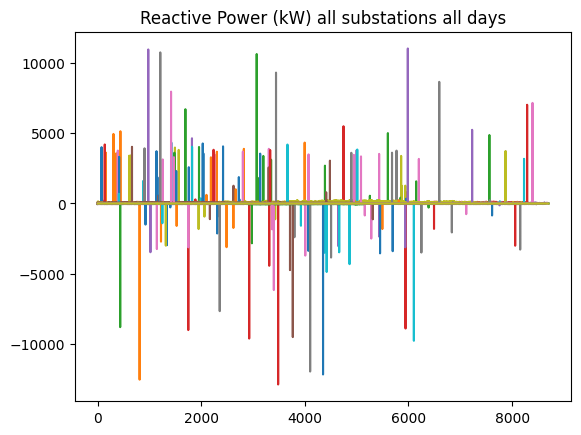

In [132]:
for substation, df in dataframes.items():
    plt.plot(df['Reactive Power [kVAr]'])
    plt.title("Reactive Power (kW) all substations all days")

In [ ]:
def detect_bad_power_values(df, upper_threshold = 1500, lower_threshold = -50):
    # Find Active Power values over 1500 kW
    bad_vals = df[(df['Active Power [kW]'] > upper_threshold) | (df['Active Power [kW]'] < lower_threshold)]
    
    drop_dates = bad_vals['Datetime'].dt.date.unique()

    df = df[~df['Datetime'].dt.date.isin(drop_dates)]
    
    return df 
    
for substation, df in dataframes.items():
    dataframes[substation] = detect_bad_power_values(df)
        

### <font color='lightgreen'> Data transformation: by season and time of week </font> 

Split by season

In [ ]:
def split_by_season(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Month'] = df['Datetime'].dt.month
    
    spring = df[(df['Month'] >= 3) & (df['Month'] <= 5)]
    summer = df[(df['Month'] >= 6) & (df['Month'] <= 8)]
    fall = df[(df['Month'] >= 9) & (df['Month'] <= 11)]
    winter = df[(df['Month'] == 12) | ((df['Month'] >= 1) & (df['Month'] <= 2))]
    
    return spring, summer, fall, winter

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}



Split the season dataframes by time of week

In [ ]:
# Split seasonal dataframes into week and week-end dataframes
def split_weekend_week(df):
    df['weekday'] = df['Datetime'].dt.weekday
    week_df = df[df['weekday'].isin([0,1,2,3,4])]
    weekend_df = df[df['weekday'].isin([5,6])]
    return week_df, weekend_df

chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        

### <font color ='lightgreen'> Data cleaning: Drop the substations with not enough data in given season/time-of-week subset </font>

In [ ]:
# Drop substations with not enough data in sub-set
drop_list = []
for substation, seasons in chopped_substation_dfs.items():
    for season, days in seasons.items():
        for time_of_week, df in days.items():
            days_with_data = len(df['Datetime'].dt.date.unique())
            if time_of_week == 'week':
                if days_with_data < 33: # 33 days is ~1/2 of the 65 days in a season during the week 
                    print(f"Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.")
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
            else:
                if days_with_data < 13: #(has less than half of weekends)
                    print(f'Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.')
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
           # print(substation, season, time_of_week, len(df))

<font color='lightgreen'> Drop the underfull substation/season/time of week combinations </font>

In [ ]:
print("number of sub-datasets to drop,", len(drop_list))
for to_drop in drop_list:
    substation = to_drop.split("_")[0]
    season = to_drop.split("_")[1]
    time_of_week = to_drop.split("_")[2]
    del chopped_substation_dfs[substation][season][time_of_week]


### <font color='lightgreen'> Data cleaning: Detect Outliers </font> 

Plot histograms

In [ ]:
def plot_peak_hour_distributions(dataframes, active):
    for substation, substation_data in dataframes.items():
        substation_data['Date'] = substation_data['Datetime'].dt.date
        substation_data['Hour'] = substation_data['Datetime'].dt.hour
        
        # Group the data by date
        daily_groups = substation_data.groupby(['Date'])

        if active:
        # Find the hour of peak Active Power for each date 
            peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
                        # Count the number of times each hour appears as the peak hour for each day
            peak_counts = peak_hour.value_counts()
            
            plt.bar(peak_counts.index, peak_counts.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Peak Hour Distribution for {substation}')
            plt.savefig(f'peak_hr_histograms/peak_hour_distribution_{substation}.png')
            plt.show()
            
        else:
                # Find the hour of peak positive and negative Reactive power for each day
            peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
            
                # Count the number of times each hour appears as the peak hour for each day
            peak_counts_max = peak_hour_max.value_counts()
            peak_counts_min = peak_hour_min.value_counts()
            
            plt.bar(peak_counts_max.index, peak_counts_max.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Positive Reactive Power Peak Hour Distribution for {substation}')
            plt.show()
            plt.bar(peak_counts_min.index, peak_counts_min.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Negative Reactive Power Peak Hour Distribution for {substation}')
            plt.show()



In [ ]:
plot_peak_hour_distributions(dataframes, active = True)

## <font color = 'orange'> Feature Extraction <font>

### <font color ='lightgreen'> Extract features for clustering (functions) </font>

Global features  </br>

Mean value of daily load pattern </br>
SD of daily load pattern </br>
Max power consumption during a day  </br>
Min power consumption during a day  </br>
Range power consumption during a day (max - min) </br>
Perc values above mean val  </br>
Sum of net loads during business hours (9am-6pm) </br>
Sum of net loads during non-business hours </br>
Skewness of the distribution of a daily load pattern  </br>
Kurtosis of distribution of a daily load pattern  </br>
Mode of 5-bin histogram for daily load pattern   </br>
Longest sub-sequence where consecutive value above mean value  </br>
Longest period of successive increase  </br>

<font color = 'orange'> to-do: integrate this estimate hot or cold function into 'extract global features'

In [ ]:
'''
This function takes in a dictionary of substation dataframes and finds:
on average how long the active power is more than 1.5 * average daily load
on average how long the active power is less than 0.75 * average daily load

NOTE: For whatever time frame we end up looking at, we may not want to compare the average of each hour to the average daily load, but rather the actual value in each hour over the entire time frame to avareage daily load, and then divide that by the number of days in the time period. Let me know. 
'''
def estimate_hot_or_cold(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    hot_times = {}
    cold_times = {}
    
    for substation, substation_df in dataframes.items():
    
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()
        
        # Get ratio of each hour to the mean
        hourly_data = hourly_data / hourly_data.mean()
        
        # Get the number of hours per day that the active power is more than 1.5 * average daily load
        hot_times[substation] = hourly_data[hourly_data > 1.25].count() 
        
        # Get the number of hours per day that the active power is less than 0.75 * average daily load
        cold_times[substation] = hourly_data[hourly_data < 0.75].count() 
    
    return hot_times, cold_times

hot_times, cold_times = estimate_hot_or_cold(dataframes)

#Plot the distribution of how many hours per day each substation is 'running hot' on average
plt.hist(list(hot_times.values()))
plt.xlabel("Number of hours above 1.5 * average daily load")
plt.ylabel("Number of substations")
plt.show()

#Plot the distribution of how many hours per day each substation is 'running cold' on average
plt.hist(list(cold_times.values()))
plt.xlabel("Number of hours below 0.75 * average daily load")
plt.ylabel("Number of substations")
plt.show()

TO-DO: Elnaz small set of features for clustering

In [ ]:
def extract_small_set_of_features(substation, df, active = True):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    first = True
    for feature_of_interest in ['Active Power [kW]', 'Reactive Power [kVAr]']:
        
    # # Set feature of interest to either active or reactive power
    # if active:
    #     feature_of_interest = 'Active Power [kW]'
    #     # group data by day to extract any staistical features across all days
        
    # else:
    #     feature_of_interest = 'Reactive Power [kVAr]'
    #     # if reactive power, group data by positive and negative and then by day 

        ##################################################################
        ##################################################################
        
        # group data by day to get daily load pattern (total energy consumed in a day)
        daily_groups = df.groupby(df['Date'])
        
        # Mean daily power consumption 
        mean_powers = daily_groups[feature_of_interest].sum()


<font color ='lightgreen'> FUNCTION: Extract global features </font>

In [ ]:
'''
Same as v2, but option to get reactive power features as well as active power features
'''

def extract_global_features_v3(substation, df, active = True):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    first = True
    for feature_of_interest in ['Active Power [kW]', 'Reactive Power [kVAr]']:
        
    # # Set feature of interest to either active or reactive power
    # if active:
    #     feature_of_interest = 'Active Power [kW]'
    #     # group data by day to extract any staistical features across all days
        
    # else:
    #     feature_of_interest = 'Reactive Power [kVAr]'
    #     # if reactive power, group data by positive and negative and then by day 

        ##################################################################
        ##################################################################
        
        # group data by day to get daily load pattern (total energy consumed in a day)
        daily_groups = df.groupby(df['Date'])
        
        # Mean daily power consumption 
        mean_powers = daily_groups[feature_of_interest].mean()
        
        # Std deviation of daily power consumption
        sd_powers = daily_groups[feature_of_interest].std()
        
        # Max power consumption during a day
        max_powers = daily_groups[feature_of_interest].max()
        
        # Min power consumption during a day
        min_powers = daily_groups[feature_of_interest].min()
        
        # Range of power consumption during a day
        range_powers = max_powers - min_powers
        
        # Percent values above mean value in each day
        above_mean_counts = [(df[(df['Date'] == date) & (df[feature_of_interest] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
        percentage_above_mean = [above_mean_count / 24 * 100 for i, above_mean_count in enumerate(above_mean_counts)]

        # Filter the dataframe to include only the hours between 9 and 17
        filtered_business_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)]
        # Group by date
        grouped_business_hours = filtered_business_hours.groupby(by=['Date'])
        # Sum of net loads during business hours (9am-6pm)
        business_hour_loads = grouped_business_hours[feature_of_interest].sum()
        
        ####################### Now for non-business hours (the opposite) #############################
        filtered_non_business_hours = df[(df['Hour'] < 9) | (df['Hour'] > 18)]
        grouped_non_business_hours = filtered_non_business_hours.groupby(by=['Date'])
        non_business_hour_loads = grouped_non_business_hours[feature_of_interest].sum()
        
        # Skewness 
        skewness_daily_load_pattern = daily_groups[feature_of_interest].sum().skew()
        
        # Kurtosis 
        kurtosis_daily_load_pattern = daily_groups[feature_of_interest].sum().kurtosis()
        
        # Mode of 5-bin histogram for daily load pattern
        hist, bin_edges = np.histogram(daily_groups[feature_of_interest].sum(), bins=5)
        mode_5_bin_histogram = bin_edges[np.argmax(hist)]
        
        if first:
            features = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
        else:
            next = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
            features.update(next)
        first = False 
    
    
    return features

    



<font color='lightgreen'> FUNCTION: Extract peak hour features <font> <br>

In [ ]:
def get_peak_hour_distribution_active(substation_data, time_intervals, time_labels):
    
    #peak_hour_part_of_day = {}
  #  for substation, substation_data in dataframes.items():
    # Extract Date and Hour columns from Datetime column 
    substation_data['Date'] = substation_data['Datetime'].dt.date
    substation_data['Hour'] = substation_data['Datetime'].dt.hour
    
    # Group the data by Date
    daily_groups = substation_data.groupby(['Date'])
    

   
    # Find the hour of peak Active Power for each date 
    peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    
    # Count the number of times each hour appears as the peak hour for each day
    peak_counts = peak_hour.value_counts()
    
    # Add the distribution to the dictionary
    # distributions[substation] = peak_counts
    most_common_peak = peak_counts.idxmax()
    for i, (start,end) in enumerate(time_intervals):
      if start <= most_common_peak < end:
        peak_part_of_day = time_labels[i]
        
    return peak_part_of_day
            
        
def get_peak_hour_distribution_reactive(substation_data, time_intervals, time_labels):
  
     # peak_hour_part_of_day = {}
    #  for substation, substation_data in dataframes.items():
      # Extract Date and Hour columns from Datetime column 
      substation_data['Date'] = substation_data['Datetime'].dt.date
      substation_data['Hour'] = substation_data['Datetime'].dt.hour
      
    # Group the data by Date
      daily_groups = substation_data.groupby(['Date'])
    
      # Find the hour of Peak positive and Valley negative Reactive power for each day
      peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
      peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
      
      # Count the number of times each hour appears as the peak hour for each day
      peak_counts_max = peak_hour_max.value_counts()
      peak_counts_min = peak_hour_min.value_counts()
      
      # Add the distributions to the dictionary
      most_common_peak_max = peak_counts_max.idxmax()
      most_common_peak_min = peak_counts_min.idxmax()
      
      for i, (start,end) in enumerate(time_intervals):
        if start <= most_common_peak_max < end:
          positive_peak_part_of_day = time_labels[i]
        if start <= most_common_peak_min < end:
          negative_peak_part_of_day = time_labels[i]
      

      return positive_peak_part_of_day, negative_peak_part_of_day


### <font color='lightgreen'> Extracting features for clustering (implementation) <font>
<font color ='lightgreen'> Extracting global features <font> <br>
<font color ='lightgreen'> Extracting peak hour features and incorporating it into 'features' dict <font>

In [ ]:
# Need to iterate through 'chopped_substation_dfs' to get the global features and peak hour distributions for each subsattion/season/time of week combination
# Then need to save the global features and peak hour distributions for each subsattion/season/time of week combination into a dataframe

# Possibly... needs to be saved in a dictionary of dataframes
# Define the time period labels
time_labels = [1, 2, 3, 4, 5, 1]
#time_labels = ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']

# Define the time period intervals
time_intervals = [(0, 5), (5, 11), (11, 14), (14, 17), (17, 22), (22, 24)]

features_dataframes = {}
active = False 
for substation, season in chopped_substation_dfs.items():
    features_dataframes[substation]  = {}
    for season_name, times_of_week in season.items():
        features_dataframes[substation][season_name] = {}
        for time_of_week, df in times_of_week.items():
            
            # Get global features in a dictionary
            features = extract_global_features_v3(substation, df, active)
            
            # Get peak hour distributions. What I really need is just for the peak hour distributions to be added to the features dictionary... hmmm... so I want a key that is 'peak hour distribution' and the value to be that distribution? but then that's different than all the other things
            
            for active in [True, False]:
                if active:
                    features['Most common Active Power peak time of day'] = get_peak_hour_distribution_active(df, time_intervals, time_labels)
                else:
                    features['Most common positive Reactive Power peak time of day'], features['Most common negative Reactive Power peak time of day'] = get_peak_hour_distribution_reactive(df, time_intervals, time_labels)                    
            
            features_dataframes[substation][season_name][time_of_week] = features 
                
        


Create features lists

In [ ]:
feature_of_interest = 'Active Power [kW]'

global_active_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
      
    ]
feature_of_interest = 'Reactive Power [kVAr]'

global_reactive_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
    ]

peak_features = ['Most common Active Power peak time of day',
                'Most common positive Reactive Power peak time of day',
                'Most common negative Reactive Power peak time of day']

active_and_reactive_features = global_active_features + global_reactive_features + peak_features

<font color ='lightgreen'> Create separate season/time-of-week dataframes for clustering <font>

In [ ]:
# Create an empty dictionary to hold the dataframes
df_dict = {}

feature_set = ['substation'] + active_and_reactive_features

# Loop through the nested dictionary
for substation, season_dict in features_dataframes.items():
    for season, time_dict in season_dict.items():
        for time_of_week, feature_dict in time_dict.items():
            # If the dataframe doesn't exist for this season/time_of_week combination, create it
            if (time_of_week, season) not in df_dict:
                df_dict[(time_of_week, season)] = pd.DataFrame(columns= feature_set)
            # Create a new row of feature data for the substation
            feature_data = {"substation": substation}
            feature_data.update(feature_dict)

            # Convert the feature data into a dataframe and append it to the corresponding dataframe in df_dict
            df_dict[(time_of_week, season)] = df_dict[(time_of_week, season)].append(feature_data, ignore_index=True)
            
            
        
# Access the dataframes using a tuple of (time_of_week, season) as the key
spring_weekday_df = df_dict[("week", "spring")]
spring_weekend_df = df_dict[("weekend", "spring")]
summer_weekday_df = df_dict[("week", "summer")]
summer_weekend_df = df_dict[("weekend", "summer")]
fall_weekday_df = df_dict[("week", "fall")]
fall_weekend_df = df_dict[("weekend", "fall")]
winter_weekday_df = df_dict[("week", "winter")]
winter_weekend_df = df_dict[("weekend", "winter")]



<font color = 'lightgreen'> Feature Correlation Matrix <font>

In [ ]:
for k,v in df_dict:
    df = df_dict[k,v]

    #df_dict[k,v]['Most common Active Power peak time of day'] = df_dict[k,v]['Most common Active Power peak time of day'].astype(float)
    df = df.astype({'Most common Active Power peak time of day':'float',
                    'Most common positive Reactive Power peak time of day':'float',
                    'Most common negative Reactive Power peak time of day': 'float'})
    
     # Build a correlatrion matrix between all the features in the dataframe (excluding cluster labels)
    corr_matrix = df.loc[:, ~df.columns.str.contains('cluster')].corr()
    
    # Build active and reactive features only correlation matrices
    ap_features_corr_matrix = df.loc[:, global_active_features + ['Most common Active Power peak time of day']].corr()
    rp_features_corr_matrix = df.loc[:, global_reactive_features + ['Most common positive Reactive Power peak time of day', 'Most common negative Reactive Power peak time of day' ]].corr()

    # Create labels for the plots
    feature = 'Active'
    active_feature_labels = [f'GF-1 ({feature})', f'GF-2 ({feature})', f'GF-3 ({feature})', f'GF-4 ({feature})', f'GF-5 ({feature})',
                             f'GF-6 ({feature})', f'GF-7 ({feature})', f'GF-8 ({feature})', f'GF-9 ({feature})', f'GF-10 ({feature})', f'GF-11 ({feature})', f'PF-1 ({feature})']
    feature = 'Reactive'
    reactive_feature_labels =[f'GF-1 ({feature})', f'GF-2 ({feature})', f'GF-3 ({feature})', f'GF-4 ({feature})', f'GF-5 ({feature})',
                             f'GF-6 ({feature})', f'GF-7 ({feature})', f'GF-8 ({feature})', f'GF-9 ({feature})', f'GF-10 ({feature})', f'GF-11 ({feature})', f'PF-1 ({feature})', f'PF-2 ({feature})']
    
    # All feature labels (reorganized so in correct order)
    all_feature_labels = active_feature_labels[:-1] + reactive_feature_labels[:-2] + ['PF-1 (Active)', 'PF-1 (Reactive)', 'PF-2 (Reactive)']
    
    
    # Create a heatmap of the correlation matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=False, fmt='.2f', square=True, xticklabels=all_feature_labels, yticklabels=all_feature_labels)

    # Add a title
    plt.title(f'All Features Correlation Matrix for {v}, {k}')
    plt.tight_layout()
    plt.savefig(f"../figures/corr_matrix_{v}_{k}.png",facecolor = 'white', edgecolor = 'black')
    plt.show()


    # Create a heatmap of the correlation matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(ap_features_corr_matrix, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=False, fmt='.2f', square=True, xticklabels=active_feature_labels, yticklabels=active_feature_labels)

    plt.title(f'Active Power Features Correlation Matrix for {v}, {k}')
    plt.tight_layout()
    plt.savefig(f"../figures/AP_corr_matrix_{v}_{k}.png",facecolor = 'white', edgecolor = 'black')
    plt.show()



    plt.figure(figsize=(10, 8))
    sns.heatmap(rp_features_corr_matrix, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=False, fmt='.2f', square=True, xticklabels=reactive_feature_labels, yticklabels=reactive_feature_labels)
    plt.title(f'Reactive Power Features Correlation Matrix for {v}, {k}')
    plt.tight_layout()
    plt.savefig(f"../figures/RP_corr_matrix_{v}_{k}.png", facecolor = 'white', edgecolor = 'black')
    plt.show()



## <font color='pink'> Extract features using IFEEL (maybe pursue later) </font>

In [ ]:
df_test = dataframes['Gloucester lane tx 1']

# Drop all unneeded columns
df_test = df_test[['Active Power [kW]', 'Datetime']]

# Drop last row from df_test
df_test = df_test[:-1]

# create a new column with the date only
df_test['Date'] = df_test['Datetime'].dt.date

# create a new column with the hour of the day
df_test['Hour'] = df_test['Datetime'].dt.hour

# identify duplicate rows based on "Date" and "Hour" columns
duplicates = df_test[df_test.duplicated(['Date', 'Hour'], keep=False)]
# Drop duplicates
df_test = df_test.drop_duplicates(['Date', 'Hour'])

#df_test.drop_duplicates(subset=['Date', 'Hour'], keep='first', inplace=True)


# Transform data from long to wide, so that date is the index and each column is a different time



df_pivot = df_test.pivot(index = 'Date', columns= 'Hour', values = 'Active Power [kW]')

# display the result
# convert integer columns to string
df_pivot.columns = df_pivot.columns.astype(str)
# convert columns to strings with format '%H:%M:%S'
df_pivot.columns = [str(hour) + ':00:00' if len(hour) > 1 else '0' + str(hour) + ':00:00' for hour in df_pivot.columns ]

df_pivot.columns



In [ ]:
# This is a demonstration case, which shows how to use IFEEL to extract interpretable features of electricity loads.
# The test dataset at different time intervals can be downloaded from https://github.com/chacehoo/IFEEL/tree/main/Test_Data
# The downloaded datasets need to be placed under the current working directory.




# # Read the downloaded data
# # df_test = pd.read_csv("IFEEL_test_data_1month_1hour.csv", header=0,index_col=0, parse_dates=False 
 
 #df_test = pd.read_csv("IFEEL/Test_Data/IFEEL_test_data_1month_30mins.csv", header=0,index_col=0, parse_dates=False)
# # df_test = pd.read_csv("IFEEL_test_data_1month_2hours.csv", header=0,index_col=0, parse_dates=False)


from IFEEL import ifeel_transformation, ifeel_extraction


# You can check the names of all global and peak-period features here.
feature_name_global = ifeel_extraction.feature_name_global
feature_name_peak = ifeel_extraction.feature_name_peak

df_test = dataframes['Gloucester lane tx 1']

# Drop all unneeded columns
df_test = df_test[['Active Power [kW]', 'Datetime']]

# Drop last row from df_test
df_test = df_test[:-1]

# create a new column with the date only
df_test['Date'] = df_test['Datetime'].dt.date

# create a new column with the hour of the day
df_test['Hour'] = df_test['Datetime'].dt.hour

# identify duplicate rows based on "Date" and "Hour" columns
duplicates = df_test[df_test.duplicated(['Date', 'Hour'], keep=False)]
# Drop duplicates
df_test = df_test.drop_duplicates(['Date', 'Hour'])

#df_test.drop_duplicates(subset=['Date', 'Hour'], keep='first', inplace=True)


# Transform data from long to wide, so that date is the index and each column is a different time
df_pivot = df_test.pivot(index = 'Date', columns= 'Hour', values = 'Active Power [kW]')

# display the result
# convert integer columns to string
df_pivot.columns = df_pivot.columns.astype(str)

# convert columns to strings with format '%H:%M:%S'
df_pivot.columns = [str(hour) + ':00:00' if len(hour) > 1 else '0' + str(hour) + ':00:00' for hour in df_pivot.columns ]



sample_interval_in_hour = 24/df_pivot.shape[1]
# note: the value of sample interval is in the unit of hour, e.g., if the interval is 30 mins, then sample_interval = 0.5.

# Parameter setting
# Business hours here are from 9 am to 5 pm
time_business_start = 9
time_business_end = 17
alphabet_size = 7    # alphabet size of SAX representation

# Data transformation
[df_raw, df_raw_diff, df_SAX_number, df_SAX_alphabet, df_SAX_number_diff] = ifeel_transformation.feature_transformation(df_pivot, alphabet_size,time_business_start,time_business_end)


# Global feature extraction for each daily profile
feature_global_all_days = pd.DataFrame()
for i in np.arange(0, df_raw.shape[0]):
    ts = df_raw.iloc[i]
    ts_diff = df_raw_diff.iloc[i]
    feature_global_all_each = ifeel_extraction.feature_global(ts, ts_diff, sample_interval_in_hour).global_all().T
    feature_global_all_days = feature_global_all_days.append(feature_global_all_each, ignore_index=True)

feature_global_all_days.columns = ifeel_extraction.feature_name_global
feature_global_all_days.head()

# Peak feature extraction for each daily profile
feature_peak_period_all_days = pd.DataFrame()
for i in np.arange(0, df_raw.shape[0]):
    ts_sax = df_SAX_number.iloc[i]
    ts_sax_diff = df_SAX_number_diff.iloc[i]
    feature_peak_all_each = ifeel_extraction.feature_peak_period(ts_sax, ts_sax_diff,alphabet_size, sample_interval_in_hour).T
    feature_peak_period_all_days = feature_peak_period_all_days.append(feature_peak_all_each, ignore_index=True)

feature_peak_period_all_days.columns = ifeel_extraction.feature_name_peak
feature_global_all_days.head()

## <font color = 'lightgreen'> PCA + Clustering <font>

<font color = 'lightgreen'>  FUNCTION: Print and plot PCA results for each dataset to determine number of components to cluster on </font> 

In [ ]:
def pca_plot(df):

    scaler = StandardScaler()
    scaler.fit_transform(df)

    pca = PCA()
    pca.fit(df)

    np.set_printoptions(precision=4, suppress=True)
    print(pca.explained_variance_ratio_)

    plt.figure(figsize = (5,4))
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components*')
    plt.ylabel('Cumulative Explained Variance')
    plt.ylim(0,1.0)
    plt.show()
for key in df_dict:
    print(key)
    df = df_dict[key].set_index('substation')
    pca_plot(df)
    
    # rule of thumb, keep 80% of the variacne

<font color = 'lightgreen'>  FUNCTION: Get pca_scores and cluster labels <font>

In [ ]:
def get_scores_pca(df, n_components):
    # We choose three components. 3 or 4 seems the right choice according to the previous graph.
    pca = PCA(n_components = n_components)
    #Fit the model the our data with the selected number of components. In our case three.
    pca.fit(df)

    pca.transform(df)
    scores_pca = pca.transform(df)
    
    return scores_pca

def cluster_on_pca_scores(df, scores_pca, n_clusters: int):
        # We have chosen four clusters, so we run K-means with number of clusters equals four.
    # Same initializer and random state as before.
    kmeans_pca = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
    # We fit our data with the k-means pa model
    kmeans_pca.fit(scores_pca)
    # We create a new data frame with the original features and add the PC scores and assigned clusters.
    df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
    df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1','Component 2', 'Component 3']
    # The last column we add contains the pea k-means clustering labels.
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    return df_segm_pca_kmeans,kmeans_pca


<font color = 'lightgreen'> Implementation: Cluster on Principle Component Scores <font>

In [ ]:
pca_cluster_results = {}
n_components = 2
range_of_k_vals = range(2,11)
for key in df_dict.keys():
    
    # Put substation in index so that PCA can work (doesn't work with strings)
    df = df_dict[key].set_index('substation')
    # Plot PCA results to determine number of components to keep 
    pca_plot(df)
    # Get PCA scores
    scores_pca = get_scores_pca(df, n_components)
    
    # Initialize the dictionary entry for this season/time of week combo 
    pca_cluster_results[key] = df
    

    
    # Run K-means on PCA scores for different numbers of clusters 
    for n_clusters in range_of_k_vals:
        # Get clustering results
        these_results,kmeans_pca = cluster_on_pca_scores(df, scores_pca, n_clusters)
        # Add results to dataframe
        pca_cluster_results[key][f'PCA_clustering_k={n_clusters}'] = np.array(these_results['Segment K-means PCA']
                                                                              
 
# Write dataframes to CSV 
# for key in pca_cluster_results:
#     df_to_write = pca_cluster_results[key].loc[:,pca_cluster_results[key].columns.str.contains('PCA_clustering', case=False)]
#     df_to_write.to_csv(f'../pca_cluster_assignments/' + str(key) + '_pca_cluster_' + str(n_components) + '.csv')
    


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def get_scores_pca(df, n_components):
    # We choose three components. 3 or 4 seems the right choice according to the previous graph.
    pca = PCA(n_components = n_components)
    #Fit the model the our data with the selected number of components. In our case three.
    pca.fit(df)

    pca.transform(df)
    scores_pca = pca.transform(df)
    
    return scores_pca

def cluster_on_pca_scores(df, scores_pca, n_clusters: int):
        # We have chosen four clusters, so we run K-means with number of clusters equals four.
    # Same initializer and random state as before.
    kmeans_pca = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
    # We fit our data with the k-means pa model
    kmeans_pca.fit(scores_pca)
    # We create a new data frame with the original features and add the PC scores and assigned clusters.
    df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
    df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1','Component 2', 'Component 3']
    # The last column we add contains the pea k-means clustering labels.
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    return df_segm_pca_kmeans,kmeans_pca


pca_cluster_results = {}
n_components = 2
range_of_k_vals = range(2,11)

# Initialize empty lists to store scores
silhouette_scores = []
davies_bouldin_scores = []
inertias = []

for key in df_dict.keys():
    
    # Put substation in index so that PCA can work (doesn't work with strings)
    df = df_dict[key].set_index('substation')
    # Plot PCA results to determine number of components to keep 
    pca_plot(df)
    # Get PCA scores
    scores_pca = get_scores_pca(df, n_components)
    
    # Initialize the dictionary entry for this season/time of week combo 
    pca_cluster_results[key] = df
    

    # Run K-means on PCA scores for different numbers of clusters 
    for n_clusters in range_of_k_vals:
        # Get clustering results
        these_results,kmeans_pca = cluster_on_pca_scores(df, scores_pca, n_clusters)
        # Add results to dataframe
        pca_cluster_results[key][f'PCA_clustering_k={n_clusters}'] = np.array(these_results['Segment K-means PCA'])
        
        # Get silhouette score and Davies Bouldin score
        silhouette = silhouette_score(scores_pca, kmeans_pca.labels_)
        davies_bouldin = davies_bouldin_score(scores_pca, kmeans_pca.labels_)
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        
        # Get inertia (within-cluster sum of squares) for elbow curve
        inertias.append(kmeans_pca.inertia_)
        
    # Plot elbow curve, silhouette scores, and Davies Bouldin index for this set of PCA scores
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    axs[0].plot(range(2, 11), inertias, '-o')
   


In [ ]:

pca_cluster_results = {}
n_components = 2
range_of_k_vals = range(2,11)
for key in df_dict.keys():
    
    # Put substation in index so that PCA can work (doesn't work with strings)
    df = df_dict[key].set_index('substation')
    # Plot PCA results to determine number of components to keep 
    pca_plot(df)
    # Get PCA scores
    scores_pca = get_scores_pca(df, n_components)
    
    # Initialize the dictionary entry for this season/time of week combo 
    pca_cluster_results[key] = df
    
    # Initialize arrays for elbow curve, silhouette scores, and Davies Bouldin index
    elbow_scores = []
    silhouette_scores = []
    davies_bouldin_scores = []
    
    # Run K-means on PCA scores for different numbers of clusters 
    for n_clusters in range_of_k_vals:
        # Get clustering results
        these_results,kmeans_pca = cluster_on_pca_scores(df, scores_pca, n_clusters)
        # Add results to dataframe
        pca_cluster_results[key][f'PCA_clustering_k={n_clusters}'] = np.array(these_results['Segment K-means PCA'])
        
        # Calculate and store elbow score
        elbow_scores.append(kmeans_pca.inertia_)
        
        # Calculate and store silhouette score
        sil_score = silhouette_score(scores_pca, kmeans_pca.labels_)
        silhouette_scores.append(sil_score)
        
        # Calculate and store Davies Bouldin index score
        db_score = davies_bouldin_score(scores_pca, kmeans_pca.labels_)
        davies_bouldin_scores.append(db_score)
        
    # Plot elbow curve
    plt.plot(range(2,11), elbow_scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Curve for {key}')
    plt.show()
    
    # Plot silhouette scores
    plt.plot(range(2,11), silhouette_scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for {key}')
    plt.show()
    
    # Plot Davies Bouldin index scores
    plt.plot(range(2,11), davies_bouldin_scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies Bouldin Index Score')
    plt.title(f'Davies Bouldin Index Scores for {key}')
    plt.show()


## <font color ='lightgreen'> K Means Clustering (w/o PCA) + Analysis </font> <br>

<font color ='lightgreen'> Function: K-Means Clustering  </font>

In [ ]:
# def k_means(df, k_values = range(2,11), active_only = False):
    
#     if active_only:
#         # Get the feature set - only active power features
#         X = df.loc[:, df.columns.str.contains('Active Power')].values
#     else:
#         # Get the feature set - all features
#         X = df.loc[:, df.columns != 'substation'].values


#     # Create an empty list to hold the silhouette scores
#     silhouette_scores = []
    
#     # Loop through each value of k
#     for k in k_values:
#         # Fit the k-means model to the feature set
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         labels = kmeans.fit_predict(X)
            
#         # Calculate the silhouette score for the clustering
#         score = silhouette_score(X, labels)
#         silhouette_scores.append(score)
        
#         # Calculate the elbow cost for the clustering
        
        
#         # Assign cluster labels to substations
#         df['cluster_{}'.format(k)] = kmeans.labels_

#     # # Assign cluster labels to substations
#     #     substation_clusters = {}
#     #     for substation in df['substation']:
#     #         substation_clusters[substation] = kmeans.labels_[i]

#     # Plot the silhouette scores for each k value
#     plt.plot(silhouette_scores)
#     plt.show()
    
#     # Save the cluster assignments 
#    # all_substation_clusters[k] = substation_clusters
    
#     return df



In [ ]:
def k_means(df, k_values = range(2,11), active_only = False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the silhouette scores and DBI and elbow cost
    silhouette_scores = []
    dbi_scores = []
    wss = []
    
    # Create empty dict to hold results
    results = {}
    
    # Create an empty dictionary to hold the data points cloest to the center
    cluster_centers = {}
    
    # Loop through each value of k
    for k in k_values:
        # Fit the k-means model to the feature set
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        # Calculate the silhouette score and DBI for the clustering
        score = silhouette_score(X, labels)
        db_index = davies_bouldin_score(X, labels)
        silhouette_scores.append(score)
        dbi_scores.append(db_index)
        
        # Assign cluster labels to substations
        df[f'cluster_{k}'] = kmeans.labels_
        
        # Calculate the elbow cost for the clustering
        kmeans.fit(X)
        wss.append(kmeans.inertia_)
        
        # Save clustering results
        results[k] = labels  
        
       # closest_points = []
       # 
       # centers = np.array(labels.cluster_centers_)    
            
        # for i in range(k):
        #     cluster_center = kmeans.cluster_centers_[i]
        #     distances = ((X - cluster_center) ** 2).sum(axis=1)
        #     closest_point_idx = np.argmin(distances)
        #     closest_point = df.iloc[closest_point_idx]
        #     closest_points.append(closest_point['substation'])
        # cluster_centers[k] = closest_points

    # Plot elbow curve
    plt.plot(k_values, wss)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WSS')
    plt.title('Elbow Curve')
    plt.show()

    # Plot the silhouette scores and DBI for each k value
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    ax[0].plot(k_values, silhouette_scores)
    ax[0].set_xlabel('Number of clusters (k)')
    ax[0].set_ylabel('Silhouette score')
    ax[0].set_title('Silhouette score for k-means clustering')
    ax[1].plot(k_values, dbi_scores)
    ax[1].set_xlabel('Number of clusters (k)')
    ax[1].set_ylabel('DBI')
    ax[1].set_title('Davies Bouldin Index for k-means clustering')
    plt.show()
    
    return df, results#, cluster_centers


In [ ]:
def k_means_v2(df, k_values = range(2,11), active_only = False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the silhouette scores and DBI and elbow cost
    silhouette_scores = []
    dbi_scores = []
    wss = []
    
    # Create empty dict to hold results
    results = {}

    # Loop through each value of k
    for k in k_values:
        # Fit the k-means model to the feature set
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        # Calculate the silhouette score and DBI for the clustering
        score = silhouette_score(X, labels)
        db_index = davies_bouldin_score(X, labels)
        silhouette_scores.append(score)
        dbi_scores.append(db_index)
        
        # Assign cluster labels to substations
        df[f'cluster_{k}'] = kmeans.labels_
        

    # Plot elbow curve
    plt.plot(k_values, wss)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WSS')
    plt.title('Elbow Curve')
    plt.show()

    # Plot the silhouette scores and DBI for each k value
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    ax[0].plot(k_values, silhouette_scores)
    ax[0].set_xlabel('Number of clusters (k)')
    ax[0].set_ylabel('Silhouette score')
    ax[0].set_title('Silhouette score for k-means clustering')
    ax[1].plot(k_values, dbi_scores)
    ax[1].set_xlabel('Number of clusters (k)')
    ax[1].set_ylabel('DBI')
    ax[1].set_title('Davies Bouldin Index for k-means clustering')
    plt.show()
    
    return df, results



<font color='lightgreen'> Implementation: K-Means Clustering 

Decide cluster number (k), present results 

</font>

In [ ]:
kmeans_dict = df_dict.copy()
kmeans_results = {}
kmeans_cluster_centers = {}
for feature_set in [False]:
    count = 0
    kmeans_results[feature_set] = {}
    kmeans_cluster_centers[feature_set] = {}
    for k,v in kmeans_dict:
        print(k,v)
        kmeans_dict[k,v], kmeans_results[feature_set][k,v] = k_means(df_dict[k,v], active_only = feature_set)



In [ ]:
# Write to csv
for k,v in kmeans_dict:
    to_write = kmeans_dict[k,v].loc[:, kmeans_dict[k,v].columns.str.contains('cluster|substation')]
    to_write.to_csv(f'../cluster_assignments/' + str(k) + '_' + str(v) + '_kmeans_cluster.csv')

### <font color = 'lightgreen'> Get list of the cluster centers for the optimal k for a particular time/week combo <font>

<font color ='lightgreen'> Get feature statistics by cluster </font>

In [ ]:
# Create a dictionary to hold the relevant values of the features for each cluster for each season/time of week combo
df_stats_numeric = {}
df_stats_string = {}

# Choose k to work with 
k = 5

# Loop through df_dict 
for key in df_dict:
        
    # Group by chosen cluster number
    df_grouped = df_dict[key].groupby(f'cluster_{k}')
    
    # Calculate the mean of each feature for each cluster for all columns that have Active Power and Reactive Power in them
    df_mean = df_grouped.agg('mean')
    
    df_mode = df_grouped.agg(pd.Series.mode)
    
    # Save stats to dictionary
    df_stats_numeric[key] = df_mean
    df_stats_string[key] = df_mode
    
    # Write to csv (first filtering out the unwated columns)
    df_mean_to_write = round(df_mean.loc[:,~df_mean.columns.str.contains('cluster')],2)
    # df_mean_to_write.to_csv(f'../example_feature_sets/cluster_{k}_GF_vals_{key[0]}_{key[1]}.csv')
    
    df_mode_to_write = round(df_mode.loc[:,~df_mode.columns.str.contains('cluster')],2)
    df_mode_to_write = df_mode_to_write.loc[:,~df_mode_to_write.columns.str.contains('substation')] 
    df_mode_to_write = df_mode_to_write.loc[:,~df_mode_to_write.columns.str.contains('Percent')] 
    # df_mode_to_write.to_csv(f'../example_feature_sets/cluster_{k}_PF_vals_{key[0]}_{key[1]}.csv')
    print(df_mode_to_write.columns)
    
    df_to_write = df_mean_to_write.merge(df_mode_to_write, on = 'cluster_5', how = 'left')
    df_to_write.to_csv(f'../example_feature_sets/cluster_{k}_feature_vals_{key[0]}_{key[1]}.csv')
    




<font color ='lightgreen'> Get representative sample from each cluster <font>

In [ ]:
# Go thru all the season and time of week dataset combos
# In each one, Filter the dataset down to each cluster one at a time (range(1,num_clust+1))
# Pick a random substation from each cluster

num_clust = 5

# Initialize dictionary to hold the filtered dataframes
representative_substations = {}

for k,v in df_dict: 
    representative_substations[k,v] = {}
    cluster_reps = []
    for cluster in range(0,num_clust):
        # Filter down to the cluster
        df = df_dict[k,v].loc[df_dict[k,v][f'cluster_{num_clust}'] == cluster]
        # Pick a random substation
        substation = df.sample(1)['substation'].values[0]
        # Filter down to the substation
        #this_cluster_rep = df.loc[df['substation'] == substation]
        # Append to the list of cluster reps (appends in order of cluster number)
        cluster_reps.append(substation)
    print(cluster_reps)
    
    
    
        # Save the df to a dictionary
    representative_substations[k,v] = cluster_reps
        # Save the df to a csv
      #  df.to_csv(f'example_feature_sets/cluster_{num_clust}_substation_{substation}_{k}_{v}.csv')
    

Get the median load profiles (or example load profile) for the representative substations
<font color = 'orange'> with error bars <font>

In [ ]:
num_clust = 5
for key in representative_substations:
    if key == ('weekend', 'summer') or key == ('week', 'winter'):
        print(key)
        cluster_reps = representative_substations[key]
        
        for cluster_number, substation in enumerate(cluster_reps):
            print(cluster_number, substation)
            dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
            fig, ax = plt.subplots(2)
            plt.style.use('seaborn')
            # Main trendlines
            ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').median(), color = 'blue')
          #  ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').mean(), color = 'blue')
            ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').median(), color = 'orange')
          #  ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').mean(), color = 'green')
            
            # Error bars
            # ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').max(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            # ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').min(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            # ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').max(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            # ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').min(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            
            # Title and Legend
            ax[0].set_title(f'Active and Reactive Power Load Profiles for cluster {cluster_number} in {key[0]}, {key[1]} \n {substation}')
            ax[0].legend(labels= ['Median Active Power'])
            ax[1].legend(labels= ['Median Reactive Power'])
            
            # Axis labels
            ax[0].set_xlabel('Hour of the Day')
            ax[0].set_ylabel('kW')
            ax[1].set_xlabel('Hour of the Day')
            ax[1].set_ylabel('kVAr')
            
            ##for i in range(2):
            #  ax[i].set_facecolor('white')
              #ax[i].set_edgecolor('black')
           #  ax[i].set_axis_bgcolor('white')
            
            # Save figure
            os.makedirs(f'../example_load_profiles/{key[0]}_{key[1]}', exist_ok = True)
            plt.tight_layout()
            plt.style.use('seaborn')
            plt.savefig(f'../example_load_profiles/{key[0]}_{key[1]}/rep_ss_load_for_{cluster_number}_(out_of_{num_clust}_clusters).png', facecolor = 'white', edgecolor = 'black')
            plt.show()
            
    
        
        
        
##### PSEUDO CODE #####
# Go to the representative substation for each cluster and look at the time series data for that substation, from the 'dataframes' dictionary
# Then get the average value of active power in each hour of the day for that substation
# Plot that... 
        

## <font color = 'red' > Fuzzy C- Means (not needed) <font>

In [ ]:
import numpy as np
import skfuzzy as fuzz

def fuzzy_c_means(df, c_values = range(2,11), active_only = False, m=2.0, error=0.005, maxiter=1000):
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty dict to hold cluster assignments for each c value
    results = {}

    # Loop through each value of c
    for c in c_values:
        # Apply fuzzy c-means clustering to the feature set
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c, m, error=error, maxiter=maxiter, init=None)
        # Calculate the cluster labels based on the maximum degree of membership
        labels = np.argmax(u, axis=0)
        # Assign cluster labels to substations
        df['cluster_{}'.format(c)] = labels
        # Save clustering results
        results[c] = labels
    
    return df, results

def fuzzy_c_means(df, c_values=range(2, 11), active_only=False, m=2, error=0.005, maxiter=1000):
    if active_only:
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        X = df.loc[:, df.columns != 'substation'].values
    
    X = X.astype(float)  # Convert X to float dtype
    
    results = {}
    for c in c_values:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c, m, error=error, maxiter=maxiter, init=None)
        labels = np.argmax(u, axis=0)
        df['cluster_{}'.format(c)] = labels
        results[c] = labels
        
    return df, results



In [ ]:
cmeans_results = {}
for feature_set in [True, False]:
    count = 0
    cmeans_results[feature_set] = {}
    for k,v in df_dict:
        df_dict[k,v], cmeans_results[feature_set][k,v] = fuzzy_c_means(df_dict[k,v], active_only = feature_set)
    

## <font color = 'lightgreen'> GMM Clustering <Font>

In [ ]:
from sklearn.mixture import GaussianMixture

def gmm_clustering(df, n_components_range=range(1, 11), active_only=False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the BIC scores
    bic_scores = []
    
    # Create empty dict to hold results
    results = {}
    
    # Loop through each value of n_components
    for n_components in n_components_range:
        # Fit the GMM model to the feature set
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        # Calculate the BIC for the clustering
        bic_scores.append(gmm.bic(X))
        
        # Save clustering results
        results[n_components] = gmm.predict(X)
        
        # Assign cluster labels to substations
         # Assign cluster labels to substations
        df[f'gmm_cluster_{n_components}'] = gmm.predict(X)
        
    # Plot the BIC scores for each n_components value
    plt.plot(n_components_range, bic_scores)
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC for Gaussian Mixture Models')
    plt.show()
    
    return df, results, bic_scores.index(min(bic_scores)) +1 # +1 because index starts at 0



In [ ]:
gmm_results = {}
bic_scores={}
gmm_dict = df_dict.copy()
for feature_set in [True, False]:
    count = 0
    gmm_results[feature_set] = {}
    bic_scores[feature_set]={}
    for k,v in gmm_dict:
        print(k,v)
        gmm_dict[k,v], gmm_results[feature_set][k,v], bic_scores[feature_set][k,v] = gmm_clustering(df_dict[k,v], active_only = feature_set)
    


In [ ]:
gmm_dict[k,v]

In [ ]:
feature_set = True
for k,v in results[feature_set]:
    print(k,v )
    print(optimal_bic)
    optimal_bic = bic_scores[feature_set][k,v]
    this_df=  pd.DataFrame(gmm_dict[k,v])
    this_df = this_df.loc[:, this_df.columns.str.contains(f'gmm_cluster_{optimal_bic}|substation')]
    this_df.to_csv(f'gmm_results/{k}_{v}_gmm.csv', index=False)
    
  #  pd.DataFrame(results[feature_set][k,v][optimal_bic]).to_csv(f'gmm_results/{k}_{v}_gmm.csv', index=False)
    
    

## <font color='white'> Results </font>

In [ ]:
for k,v in results[True]:
    print(k,v, results[True][k,v])

In [ ]:
for k,v in results[True]:
    cluster_assignments = results[True][k,v]
    df = pd.DataFrame(cluster_assignments)
    df.to_csv(f'cluster_assignments/{k}_{v}.csv')
#     for num_clust, labels in cluster_assignments.items():
#         # Create dataframe where each column has the cluster assignments for each k value 
#         df[f'cluster_{num_clust}'] = labels
        
#         df = pd.DataFrame(labels, columns = ['labels']).sort_values(by ='labels')


# df.to_csv(f'cluster_assignments/{k}_{v}_numclust=_{num_clust}.csv')
#        # cluster_assignments.sort_values(by=['cluster_6']).to_csv(f'cluster_assignments/{k}_{v}.csv')
    

In [ ]:
#k = 5
for k,v in df_dict:
    print(k,v)
  #  df_dict[k,v][]
    cluster_assignments = df_dict[k,v][['substation', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10']]
   # print(np.array(cluster_assignments.sort_values(by=['cluster_6'])))
  #  cluster_assignments.sort_values(by=['cluster_6']).to_csv(f'cluster_assignments/{k}_{v}.csv')
    cluster_assignments.to_csv(f'cluster_assignments/{k}_{v}.csv')
    
    


## <font color = 'pink'> pk prd features (not used) </font>

Peak period features </br>

No. of peak periods  </br>
Occurrence time (starting time) of each peak period </br>
Shortest time interval between peaks if more than one peak exists  </br>
Duration of each peak  </br>
Occurrence time of longest peak period  </br>
Duration longest peak period  </br>
Upward slope of longest peak  </br>
Downward slope of the longest peak

In [ ]:

def find_peak_period_features(data, alphabet_size=3, window_size=30, threshold=0.2):
    """
    Identifies peak period features in a time series using Symbolic Aggregate Approximation (SAX).
    
    Parameters:
        - data: a list or numpy array containing the time series data
        - alphabet_size: the number of symbols to use in the SAX representation (default is 3)
        - window_size: the size of the sliding window to use (default is 30)
        - threshold: the threshold value used to identify peak periods (default is 0.2)
    
    Returns:
        - A list of tuples, where each tuple contains the start and end index of a peak period.
    """
    
    sax = SAX(wordSize=window_size//alphabet_size, alphabetSize=alphabet_size) # Initialize the SAX object
    
    # Transform the time series data into a SAX representation
    sax_data = sax.to_letter_rep(data)
    
    # Compute the frequencies of each symbol in the SAX representation
    freqs = [sax_data.count(sym) / len(sax_data) for sym in sax.get_symbols()]
    
    # Find the threshold value for identifying peak periods
    mean_freq = sum(freqs) / len(freqs)
    std_dev_freq = (sum((f - mean_freq)**2 for f in freqs) / len(freqs))**0.5
    peak_threshold = mean_freq + std_dev_freq * threshold
    
    # Find the indices of the start and end of each peak period
    peak_periods = []
    in_peak_period = False
    for i in range(len(sax_data)):
        if freqs[sax_data[i]] >= peak_threshold:
            if not in_peak_period:
                peak_start = i
                in_peak_period = True
        else:
            if in_peak_period:
                peak_periods.append((peak_start * window_size, i * window_size))
                in_peak_period = False
    
    if in_peak_period: # Handle the case where a peak period continues to the end of the data
        peak_periods.append((peak_start * window_size, len(data)))
    
    return peak_periods


In [ ]:
from tslearn.piecewise import SymbolicAggregateApproximation
import numpy as np

# Create a random time series
X = np.array(dataframes['76 Church Road']['Active Power [kW]'])

# Define the SAX transformation parameters
n_bins = 4
strategy = 'uniform'
window_size = 20

# Create the SAX object and transform the time series
sax = SymbolicAggregateApproximation(n_segments=5, alphabet_size_avg=n_bins)
X_sax = sax.fit_transform(X.reshape(1, -1))

# Print the transformed time series
print(X_sax)



In [ ]:


def sax(time_series, alphabet_size, n_segments):
    # Helper function to convert the time series into symbolic representations using SAX
    # Returns the symbolic representations
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))
    kmeans = KMeans(n_clusters=alphabet_size, random_state=0).fit(scaled_data)
    distances = np.min(cdist(scaled_data, kmeans.cluster_centers_, 'euclidean'), axis=1)
    thresholds = np.percentile(distances, np.linspace(0, 100, alphabet_size + 1)[1:-1])
    symbolic_representation = np.zeros(len(scaled_data))
    for i in range(1, alphabet_size):
        symbolic_representation[distances <= thresholds[i-1]] = i
    symbolic_representation = np.array_split(symbolic_representation, n_segments)
    symbolic_representation = [''.join([str(int(symbol)) for symbol in segment]) for segment in symbolic_representation]
    return symbolic_representation

# First, we need to group the data by day
grouped = substation_df.groupby(by=[substation_df['date'].dt.date])

# Next, we need to iterate through each day to convert the time series into symbolic representations using SAX
peak_periods = []
for date, group in grouped:
    symbolic_representation = sax(group['Active Power [kW]'].values, 5, 24)
    peak_periods.append({
        'date': date,
        'symbolic_representation': symbolic_representation,
    })

# Now we can extract the various peak period features from the symbolic representations
number_of_peak_periods = []
occurrence_time_of_peaks = []
shortest_time_interval_between_peaks = []
duration_of_peaks = []
occurrence_time_of_longest_peak = []
duration_longest_peak = []
for period in peak_periods:
    peaks = [i for i, symbol in enumerate(period['symbolic_representation']) if symbol.count('1') >= 4]
    if peaks:
        number_of_peak_periods.append(len(peaks))
        occurrence_time_of_peaks.append([substation_df[substation_df['date'].dt.date == period['date']].iloc[peak]['date'] for peak in peaks])
        shortest_time_interval_between_peaks.append(min
####

    shortest_interval = None
    for i in range(1, len(peaks)):
        interval = peaks[i] - peaks[i-1]
        if shortest_interval is None or interval < shortest_interval:
            shortest_interval = interval
    shortest_time_interval_between_peaks.append(shortest_interval)

    peak_durations = []
    for peak in peaks:
        start = peak
        end = peak
        while end < len(period['symbolic_representation']) - 1 and period['symbolic_representation'][end + 1] == '1':
            end += 1
        peak_durations.append(end - start + 1)
    duration_of_peaks.append(peak_durations)

    longest_peak_duration = 0
    longest_peak_occurrence = None
    for i, duration in enumerate(peak_durations):
        if duration > longest_peak_duration:
            longest_peak_duration = duration
            longest_peak_occurrence = occurrence_time_of_peaks[-1][i]
    occurrence_time_of_longest_peak.append(longest_peak_occurrence)
    duration_longest_peak.append(longest_peak_duration)

# To find the upward and downward slopes of the longest peak, we need to access the original time series data
upward_slope_longest_peak = []
downward_slope_longest_peak = []
for i, period in enumerate(peak_periods):
    date = period['date']
    group = substation_df[substation_df['date'].dt.date == date]
    longest_peak_start = group[group['date'] == occurrence_time_of_longest_peak[i]].index[0]
    longest_peak_end = longest_peak_start + duration_longest_peak[i] - 1
    longest_peak = group[longest_peak_start:longest_peak_end+1]['Active Power [kW]'].values
    upward_slope = (longest_peak[-1] - longest_peak[0]) / duration_longest_peak[i]
    downward_slope = (longest_peak[0] - longest_peak[-1]) / duration_longest_peak[i]
    upward_slope_longest_peak.append(upward_slope)
    downward_slope_longest_peak.append(downward_slope)


In [ ]:
# substation_df = df
# def find_peaks(power_series):
#     # Helper function to find the peaks in a time series
#     # Returns a list of indeces of peak hours, where peak is defined as an hour with higher active power than both the previous and next hour  
#     peaks = []
#     for i in range(1, len(power_series) - 1):
#         if power_series[i] > power_series[i-1] and power_series[i] > power_series[i+1]:
#             peaks.append(i)
#     return peaks

# # Group data by day
# grouped = substation_df.groupby(by=[substation_df['Date']])

# # Next, we need to iterate through each day to find the peak periods
# peak_periods = []
# for date, group in grouped:
#     peaks = find_peaks(group['Active Power [kW]'].values)
#     if peaks:
#         peak_periods.append({
#             'date': date,
#             'peaks': peaks,
#         })

# # Now we can extract the various features for each day
# number_of_peak_periods = [len(period['peaks']) for period in peak_periods]
# occurrence_time_of_peaks = [substation_df.iloc[period['peaks'][0]]['Date'] for period in peak_periods]
# duration_of_peaks = []
# longest_peak_duration = []
# longest_peak_start = []
# longest_peak_end = []
# longest_peak_upward_slope = []
# longest_peak_downward_slope = []
# for period in peak_periods:
#     peaks = period['peaks']
#     date = period['date']
#     peak_durations = [peaks[i+1] - peaks[i] for i in range(len(peaks) - 1)]
#     duration_of_peaks.append(peak_durations)
#     if peak_durations:
#         longest_peak_index = np.argmax(peak_durations)
#         longest_peak_start.append(substation_df.iloc[peaks[longest_peak_index]]['Date'])
#         longest_peak_end.append(substation_df.iloc[peaks[longest_peak_index + 1]]['Date'])
#         longest_peak_duration.append(peak_durations[longest_peak_index])
#         longest_peak_values = group['Active Power [kW]'].iloc[peaks[longest_peak_index]:peaks[longest_peak_index + 1] + 1].values
#         longest_peak_upward_slope.append(np.polyfit(range(len(longest_peak_values)), longest_peak_values, 1)[0])
#         longest_peak_downward_slope.append(np.polyfit(range(len(longest_peak_values[::-1])), longest_peak_values[::-1], 1)[0])
#     else:
#         longest_peak_duration.append(None)
#         longest_peak_start.append(None)
#         longest_peak_end.append(None)
#         longest_peak_upward_slope.append(None)
       




# daily_groups =df.groupby(['Date'])
# peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
# peak_hour

# <font color='orange'> To-Do: </font>
0. Organize Jupyter notebook file-- put all the pre-processing in one cell <br>
1. Extract small set of features given by Elnaz <br>
2. Clustering on small set of features given by Elnaz <br>
3. Implement threshold min distance for substation assignment  <font color = 'lightgreen'> done </font><br>
4. Plot PCA clustering results on map and send to Elnaz/Scot <br>
5. Repeat step 4 with the KMeans-only clustering on the small set of features given by Elnaz <br>
6. Compare PCA clustering results with the Land Use statistics
 

# <font color = 'orange'> Plot results on map <font>

Read in substation location data

In [4]:
substations = pd.read_csv('../substation_descriptive_data.csv')
substations['substation'] = substations['Substation Site']
substations = substations[['substation', 'Latitude', 'Longitude']]
substations.set_index('substation', inplace= True)
substations['Longitude'] = substations['Longitude'] * -1
substations


,Latitude,Longitude
substation,,
Bridge View Watlington Road,51.727159,-1.196552
rose hill community centre,51.726248,-1.231316
Desborough crescent,51.724593,-1.232681
Nowell road,51.724365,-1.231462
Thames View Road,51.723239,-1.233933
...,...,...
chepstow drive,51.895165,-1.173141
Chilton Garden Centre,51.570329,-1.300191
Rivermead Road SS,51.726210,-1.237626


Join substation location data with substation clustering results

In [5]:
saved_results = {}
for k,v in pca_cluster_results:
    df= pca_cluster_results[k,v]
    df.index = df.index.str.lower().str.strip() # so that the dataframe indeces match up with the substations dataframe
    substations.index = substations.index.str.lower().str.strip()
    saved_results[k,v] = df.join(substations)


NameError: name 'pca_cluster_results' is not defined

### Folium plot

In [ ]:
df = df[df['Latitude'].isna() == False]
df['Longitude'] = -1 * df['Longitude']
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=4)
for index, row in df.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], 
                  popup=f"{index}, Cluster: {row['Cluster']}",
                  icon=folium.Icon(color='red' if row['Cluster'] == 1 else 'blue' if row['Cluster'] == 2 else 'green')
                 ).add_to(m)

m.save('../maps/pca_clusters_k=5_week_summer.html')
m

### Shapefile based plot

In [ ]:



# Set the directory where the shapefiles are stored
dir_path = '../OS OpenMap Local (ESRI Shape File) SU/data/'

# Create an empty GeoDataFrame to hold the merged data
merged_gdf = gpd.GeoDataFrame()
count = 0
# Loop through all files in the directory with the .shp extension
for filename in os.listdir(dir_path):
    if filename.endswith('.shp'):
        count +=1
        print(count)
        # Read in the shapefile as a GeoDataFrame
        gdf = gpd.read_file(os.path.join(dir_path, filename))
        
        # Append the GeoDataFrame to the merged data
        merged_gdf = merged_gdf.append(gdf, ignore_index=True)
        



        
dir_path = '../OS OpenMap Local (ESRI Shape File) SP/data/'
for filename in os.listdir(dir_path):
    if filename.endswith('.shp'):
        count +=1
        print(count)
        # Read in the shapefile as a GeoDataFrame
        gdf = gpd.read_file(os.path.join(dir_path, filename))
        
        # Append the GeoDataFrame to the merged data
        merged_gdf = merged_gdf.append(gdf, ignore_index=True)
        

# # Convert your data to a geodataframe
# geometry = gpd.points_from_xy(df.Longitude, df.Latitude)
# geo_df = gpd.GeoDataFrame(data, geometry=geometry)

# # Make sure the CRS matches
# geo_df.crs = map_df.crs

# # Plot the map and data
# fig, ax = plt.subplots(figsize=(10, 10))
# map_df.plot(ax=ax, alpha=0.4, color='grey')
# geo_df.plot(ax=ax, markersize=2, color='red', marker='o')
# plt.show()


In [ ]:
merged_gdf.plot()

# <font color ='lightgreen'> Combine Consumer Type Data with Substation Data <font>

In [8]:
consumer_data = pd.read_csv('../Dancing_types.csv')
# Define the projection of the input coordinates (OSGB36)
input_proj = pyproj.Proj(init='epsg:27700')

# Define the projection of the output coordinates (WGS84)
output_proj = pyproj.Proj(init='epsg:4326')

# Transform the coordinates
consumer_data['Longitude'], consumer_data['Latitude'] = pyproj.transform(input_proj, output_proj, consumer_data['X'], consumer_data['Y'])
consumer_data = consumer_data[['Longitude', 'Latitude', 'LANDUSEDES']]
consumer_data.head(5)

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_84800/2550064635.py:1: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  consumer_data = pd.read_csv('../Dancing_types.csv')
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_s

,Longitude,Latitude,LANDUSEDES
0,-1.668356,51.680892,Land
1,-1.390224,52.091386,Residential
2,-1.390094,52.091374,Residential
3,-1.198956,51.949496,Parent Shell
4,-1.242316,51.848319,Residential



Assign Consumers to Substations based on location



In [9]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

def find_nearest_substation(df1, df2, threshold_distance):
    """
    Given two dataframes, df1 with columns ['Latitude', Longitude'] and an index 'Substation',
    and df2 with columns ['Land Uses', 'Latitude', 'Longitude'], returns a dataframe with
    columns ['Land Uses', 'Latitude', 'Longitude', 'Nearest Substation'], where
    'Nearest Substation' is the index of the nearest substation in df1 for each 'Land Uses'
    observation.
    """
    # calculate distances between all pairs of coordinates
    distances = cdist(df1[['Latitude', 'Longitude']], df2[['Latitude', 'Longitude']])

    # find the nearest substation for each 'Land Use' observation
    nearest_substations = df1.index[np.argmin(distances, axis=0)]
    nearest_substation_distances = np.min(distances, axis=0)

    # add 'Nearest Substation' column to df2
    df2['Nearest Substation'] = nearest_substations
    df2['Nearest Substation Distance'] = nearest_substation_distances
    df2 = df2[df2['Nearest Substation Distance'] < threshold_distance] # only keep observations within threshold distance (km) of a substation

    df_count = pd.crosstab(index=df2['Nearest Substation'], columns=df2['LANDUSEDES'], normalize = 'index')

    return df2, df_count

result_df, df_count = find_nearest_substation(substations, consumer_data, threshold_distance = 1)
df_count.to_csv('../consumer_data_counts_by_substation.csv')